In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sc
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

def dataset(dataFile, labelFile):
    dataFile = "./communication/" + dataFile
    labelFile = "./communication/" + labelFile
    my_data = sc.loadmat(dataFile)
    my_labels = sc.loadmat(labelFile)
    my_data = my_data['Y']
    X = my_labels['L_S_x']
    myOrig = table_data(my_data, my_labels['L_Constellations'][0], X)
    myTable = assign_labels(myOrig)
    return myTable

def table_data(my_data, cons, label):
    block = my_data.shape[1]
    my_data_size = my_data.shape[0] * block
    my_data_div = my_data.T.reshape(my_data_size,)
    cons_array = np.array([[cons[i]]*my_data.shape[0] for i in range(0,block)]).reshape(my_data_size,)
    block_array = np.array([([i+1]*my_data.shape[0])for i in range(0, block)]).reshape(my_data_size,)
    label_array = label.T.reshape(my_data_size,)
    test_pd = pd.DataFrame({'real':my_data_div.real,'imag':my_data_div.imag,
            'cons':cons_array, 'block':block_array,
            'label':label_array})
    return test_pd

def assign_labels(myTable):
    myTest = myTable.copy()
    myTest.loc[myTest.cons==2, 'label'] = myTest.loc[myTest.cons==2, 'label']+4
    myTest.label = myTest.label-1
    return myTest


from numpy.random import default_rng
def training_set(myTable):
    block = myTable.shape[0]
    rng = default_rng()
    sample_size = int(0.8 * block)
    numbers = rng.choice(range(1, block + 1), size=sample_size, replace=False)
    training_dataset = myTable[myTable.block.isin(numbers)]
    return training_dataset

def test_set(myTable, training_dataset):
    remaining = myTable.drop(training_dataset.index)
    return remaining



def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(50, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(20)
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(0.01),
                 metrics=['accuracy'])
    return model

def get_total_loss(predict_label, true_label):
    i = 0
    for j in range(len(predict_label)):
        prediction = np.argmax(predict_label[j])
        if prediction != true_label[j]:
            i = i + 1
    return i/len(predict_label)

datas = "INR30data"
labels = "INR30labels"


def get_training(myTable, epochs, files):
    train_dataset = training_set(myTable)
    test_dataset = test_set(myTable, train_dataset)
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()
    train_labels = pd.DataFrame([train_features.pop('label')]).T
    test_labels = pd.DataFrame([test_features.pop('label')]).T
    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(train_features))
    dnn_real_model = build_and_compile_model(normalizer)
    history = dnn_real_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        epochs=epochs)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    test_results = {}
    test_results['signal'] = dnn_real_model.evaluate(
        test_features,
        test_labels, verbose=0)
    probability_model = tf.keras.Sequential([dnn_real_model,
                                             tf.keras.layers.Softmax()])
    predictions = probability_model.predict(test_features)
    '''
    plt.clf()
    plot_loss(history)
    plt.savefig('./results/'+files, dpi=300, bbox_inches='tight')
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()
    hist = hist.append(test_results, ignore_index=True)
    hist.to_csv('./results/' + files + '.csv', index=False)
    '''
    return [predictions, test_labels]



def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Ireal]')
    plt.legend()
    plt.grid(True)


def prediction(model, testTable, test_results, fileNanme):
    test_features = testTable.copy()
    test_labels = pd.DataFrame([test_features.pop('label')]).T
    test_results[fileNanme] = model.evaluate(
        test_features,
        test_labels, verbose=0)

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Ireal]')
    plt.legend()
    plt.grid(True)

In [2]:
myTable = dataset("INR30data", "INR30labels")

In [4]:
my_data = "my_data"
my_labels = "my_labels"
INR30data = "INR30data"
INR30labels = "INR30labels"
INR30with90data = "INR30with90data"
INR30with90labels = "INR30with90labels"
noise30data = "noise30data"
noise30label = "noise30label"

myTable = dataset(my_data, my_labels)
INR30Table = dataset(INR30data, INR30labels)
INR30with90Table = dataset(INR30with90data, INR30with90labels)
noise30Table = dataset(noise30data, noise30label)

test = [myTable, INR30Table, INR30with90Table, noise30Table]
name = [my_data, INR30data, INR30with90data, noise30data]
result = {}

In [17]:
my_data = "my_data"
my_labels = "my_labels"
myTable = dataset(my_data, my_labels)

In [5]:
results = get_training(INR30Table, 10, "normal")

Epoch 1/10
1002/1002 [==============================] - 1s 798us/step - loss: 0.9242 - accuracy: 0.6669 - val_loss: 0.7183 - val_accuracy: 0.6831
Epoch 2/10
1002/1002 [==============================] - 1s 682us/step - loss: 0.5803 - accuracy: 0.7395 - val_loss: 0.4864 - val_accuracy: 0.7620
Epoch 3/10
1002/1002 [==============================] - 1s 688us/step - loss: 0.4401 - accuracy: 0.7925 - val_loss: 0.3872 - val_accuracy: 0.8085
Epoch 4/10
1002/1002 [==============================] - 1s 681us/step - loss: 0.3704 - accuracy: 0.8167 - val_loss: 0.4604 - val_accuracy: 0.7795
Epoch 5/10
1002/1002 [==============================] - 1s 675us/step - loss: 0.3491 - accuracy: 0.8254 - val_loss: 0.3722 - val_accuracy: 0.8139
Epoch 6/10
1002/1002 [==============================] - 1s 683us/step - loss: 0.3315 - accuracy: 0.8323 - val_loss: 0.3685 - val_accuracy: 0.8237
Epoch 7/10
1002/1002 [==============================] - 1s 679us/step - loss: 0.3108 - accuracy: 0.8381 - val_loss: 0.3667 -

In [287]:
predictions = []
for i in range(len(results[0])):
    predictions.append(np.argmax(results[0][i]))
len(results[0])

9950

In [7]:
test1 = tf.math.confusion_matrix(predictions, results[1].to_numpy()).numpy()

In [8]:
test_data = pd.DataFrame(test1)

In [40]:
cons_4 = test_data[:4]

In [39]:
cons_16 = test_data[4:]

In [65]:
cons_4_error = (cons_4.iloc[:, 4:].sum().sum())/cons_4.sum().sum()
cons_16_error = (cons_16.iloc[:, :4].sum().sum())/cons_4.sum().sum()

In [173]:
symbol_error_results_4

array([[0.37413518, 0.12403101],
       [0.        , 0.13003663]])

In [172]:
symbol_error_results_4 = np.array([1-cons_4.iloc[i,i]/cons_4.iloc[i,:].sum() for i in range(4)]).reshape(2,2)

In [163]:
symbol_errro_results_16 = np.array([1-cons_16.iloc[i-4,i]/cons_16.iloc[i-4,:].sum() for i in range(4,20)]).reshape(4,4)

In [176]:
symbol_error_results_4 = pd.DataFrame(symbol_error_results_4)
symbol_errro_results_16

array([[0.        , 0.02866242, 0.10693642, 0.06270627],
       [0.0060241 , 0.23275862, 0.1550152 , 0.04731861],
       [0.11016949, 0.0546875 , 0.02931596, 0.00923077],
       [0.01333333, 0.05135952, 0.07387863, 0.05792683]])

In [116]:
symbol_errro_results_16 

[0.0,
 0.0286624203821656,
 0.10693641618497107,
 0.06270627062706269,
 0.0060240963855421326,
 0.23275862068965514,
 0.1550151975683891,
 0.04731861198738174,
 0.11016949152542377,
 0.0546875,
 0.02931596091205213,
 0.009230769230769265,
 0.013333333333333308,
 0.051359516616314216,
 0.07387862796833777,
 0.057926829268292734]

In [117]:
import seaborn as sns

Text(0.5, 15.0, 'Predicted label')

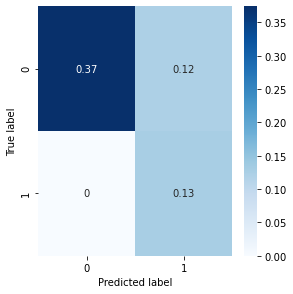

In [175]:
plt.figure(figsize = (4,4))
sns.heatmap(symbol_error_results_4, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [375]:
dataFile = "./communication/data1"
labelFile = "./communication/data1_label"
my_data = sc.loadmat(dataFile)
my_labels = sc.loadmat(labelFile)
my_data = my_data['Y']
X = my_labels['L_S_x']

In [367]:
def plot_heatmap(ax, symbol_error, cons_error):
    df = sns.heatmap(symbol_error, annot=True,cmap=plt.cm.Blues, ax=ax)  
    df.xaxis.tick_top()
    df.set_xlabel(['P(cons error)= {:.2f}'.format(cons_error)]) 

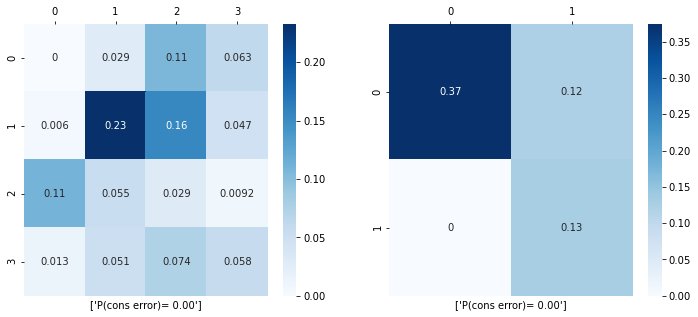

In [374]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
plot_heatmap(ax1, symbol_errro_results_16, cons_16_error)
plot_heatmap(ax2, symbol_error_results_4, cons_4_error)
plt.show()
plt.save()